In [70]:
import numpy as np
import os
import os.path
from os import path
import sys
import glob
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.graph_objs import *
import plotly.express as px
import hdbscan
import pandas as pd
import umap
from graviti import *
import networkx as nx
from scipy import sparse, linalg
import warnings
warnings.filterwarnings('ignore')

In [71]:
def clustering(embedding,min_cluster_size,min_samples,plot_tree):
    clusterer = hdbscan.HDBSCAN(min_samples=min_samples, 
                                min_cluster_size=min_cluster_size, 
                                gen_min_span_tree=True)
    clusterer.fit(embedding) #cluster positions
    if plot_tree:
        clusterer.condensed_tree_.plot(select_clusters=True, 
                                   selection_palette=sns.color_palette("Set2",len(clusterer.labels_)))
    return clusterer

In [33]:
def show_cluster(xyz):
    x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
    fig = go.Figure(data=[go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=1,
            opacity=0.75
        )
    )])
    # tight layout
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.write_html('test.html', auto_open=True)

def scattered_wsi(df,x,y,hue,size,opacity,auto_open,filename):
    fig = px.scatter(df,
                     x=x, y=y,color=hue,
                     width=800, height=800,
                     color_discrete_sequence=px.colors.qualitative.Set2)
    fig.update_traces(marker=dict(size=size,opacity=opacity))
    fig.update_layout(template='simple_white')
    fig.update_layout(legend= {'itemsizing': 'constant'})
    fig.write_html(filename+'.spatial_projection.FOV.html', auto_open=auto_open)
    return 

In [44]:
def mm(A,times): # multiply A times-times
    if times > 0:
        M = A.dot(A)
    for t in range(1,times):
        newM = A.dot(M)
        M = newM
    return M

In [155]:
def smoothed_covd(A,data,r): # given graph and morphological data returns a descriptor averaged in a radius r
    M = mm(A,r)
    row_idx, col_idx = M.nonzero()
    dim = int(0.5*data.shape[1]*(data.shape[1]-1)+data.shape[1])
    descriptor = np.zeros((data.shape[0],dim))
    for row_ID in range(A.shape[0]):
        mask = row_idx == row_ID # the non-zero elements idx at row rowID
        a = M[row_ID,col_idx[mask]] # the non-zero elements entries at row rowID, representing the weight of the node j morphology wrt node i
        morphology = data[col_idx[mask],:] # get the morphologies of the nodes path-connected to row_ID
        #morphology = np.vstack((data[row_ID,:],morphology)) # add the row_ID node
        #a = np.hstack(([1],a.data)) # add the weight of the local node !!!it has to be the max of the weights!!!
        C = np.cov(morphology,rowvar=False,aweights=a.data) # the covd for row_ID weighted with paths
        iu1 = np.triu_indices(C.shape[1]) # the indices of the upper triangular part
        covd2vec = C[iu1]
        descriptor[row_ID,:] = covd2vec
    return descriptor

In [ ]:
#dirname = '/home/garner1/Work/pipelines/WSI-analysis/SG/pipeline/data/id_52'  #sys.argv[1] # the directory where features.npz files are located
dirname = '../h5/id_52/'
sample = '52' #sys.argv[2]  # the sample id

counter = 0
for f in glob.glob(dirname+'/*features.npz'): # for every fov
    counter += 1
    if counter == 1:            # set up the data arrays
        data = np.load(f,allow_pickle=True)
        fov = data['fov']
        xy = data['centroids']
        morphology = data['morphology']
    else:                       # update the data arrays
        data = np.load(f,allow_pickle=True)
        fov = np.vstack((fov,data['fov']))
        xy = np.vstack((xy, data['centroids']))
        morphology = np.vstack((morphology, data['morphology']))

# Create dataframes
df_fov = pd.DataFrame(data=fov, columns=['fov_row','fov_col'])
df_xy = pd.DataFrame(data=xy, columns=['cx','cy'])
df_morphology = pd.DataFrame(data=morphology, columns=['area','perimeter','solidity','eccentricity','circularity','mean_intensity','std_intensity'])

# Concatenate all dataframes
df = pd.concat([df_fov,df_xy, df_morphology],axis=1)

In [107]:
# filter by percentiles in morphologies (hardcoded in function filtering)
fdf = filtering(df).sample(n=10000)

In [198]:
# Get the positions of centroids 
pos = fdf[fdf.columns[2:4]].to_numpy()
nn = 200 # number of nearest neighbor in umap
print('Building the UMAP graph')
filename = '../py/'+str(sample)+'.graph.npz' # the adj sparse matrix
if False:#path.exists(filename):
    print('The graph already exists')
    A = sparse.load_npz(filename) 
else:
    print('Creating the graph')
    A = space2graph(pos,nn)
    sparse.save_npz(filename, A)
    
filename = '../py/'+str(sample)+'.graph.pickle'    # the networkx obj
if False:#path.exists(filename):    
    print('The network already exists')
    G = nx.read_gpickle(filename)
else:
    print('Creating the network')
    G = nx.from_scipy_sparse_matrix(A, edge_attribute='weight')
    nx.write_gpickle(G, filename)

Building the UMAP graph
Creating the graph
Creating the network


In [199]:
features = ['area',
            #'perimeter',
            #'solidity',
            'eccentricity','circularity',
            'mean_intensity',
            #'std_intensity',
            'cov_intensity']
data = fdf[features].to_numpy()

In [200]:
radius = nn 
data_smooth = smoothing(A,data,radius) # to smooth morphology

In [201]:
radius = 1
descriptor = smoothed_covd(A,data_smooth,radius) # to smooth descriptors

Once the descriptor is generated, we can represent it with UMAP.

Use nn, radius in smoothing and radius in smoothed_covd to tune the low dimensional representation

In [202]:
embedding = umap.UMAP(min_dist=0.0,
                      n_components=3,
                      random_state=42).fit_transform(descriptor)

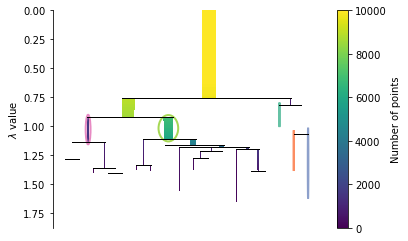

In [207]:
# Density based clustering of the embedding
min_cluster_size = 100 #parameters
min_samples = 100       #parameters
clusterer = clustering(embedding,min_cluster_size,min_samples,True)

In [208]:
df_projection = pd.DataFrame({'x': fdf['cx'],
                              'y': fdf['cy'],
                              'cluster': clusterer.labels_},
                             columns=['x','y','cluster'])
df_projection['color'] = df_projection['cluster'].apply(str)
filters = df_projection['cluster'] > -1
scattered_wsi(df_projection[filters],'x','y','color',5,1,True,'test')

In [190]:
df_cloud = pd.DataFrame({'x': embedding[:,0],
                         'y': embedding[:,1],
                         'z': embedding[:,2],
                         'cluster': clusterer.labels_},
                         columns=['x','y','z','cluster'])
df_cloud['color'] = df_cloud['cluster'].apply(str)
filters = df_cloud['cluster'] > -2
fig = px.scatter_3d(df_cloud[filters], x="x", y="y", z="z", color="color", hover_name="color")
fig.update_traces(marker=dict(size=5,opacity=0.5),selector=dict(mode='markers'))
fig.write_html('test.html', auto_open=True)